# Time series .csv from water detection 

Author: Morgane Magnier (morgane.magnier@vattenfall.com)

Copyright © 2024 Magnier Morgane 

This notebook is part of a thesis project. The copyright of the thesis itself belongs to the student Morgane Magnier.  

**Rights and Intellectual Property**:  
- Vattenfall has the right to use the findings, methods, and conclusions of this thesis in its operations.  
- Any material generated within the framework of this thesis that is subject to intellectual property protection (e.g., source code, computer program, design, or invention) belongs to Vattenfall, unless otherwise agreed in writing.  

Permission is granted to view, copy, and share this notebook for **educational or personal purposes only**, provided that this notice is included in all copies.  

---

In [1]:
import pandas as pd
import ee

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()
        
import os
import plotly.express as px

# Climate values

In [2]:
start_date = '2014-01-01'
end_date = '2024-12-31'
roi = ee.Geometry.Polygon([[[17.204933,60.402663],[17.204933,60.455525],[17.2645,60.455525],[17.2645,60.402663],[17.204933,60.402663]]])

# Charger les collections de données climatiques (température, précipitations, etc.)
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR") \
            .filterDate(start_date, end_date) \
            .filterBounds(roi)

# Fonction pour extraire les moyennes mensuelles de température, précipitations, profondeur de glace, et couverture de neige
def extract_monthly_means(image):
    temperature = image.select('temperature_2m').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=roi, scale=1000).get('temperature_2m')
    precipitation = image.select('total_precipitation_sum').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=roi, scale=1000).get('total_precipitation_sum')
    ice_in_depth = image.select('lake_ice_depth').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=roi, scale=1000).get('lake_ice_depth')
    snow_cover = image.select('snow_cover').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=roi, scale=10000).get('snow_cover')
    date = ee.Date(image.get('system:time_start'))
    return ee.Feature(None, {
        'date': date, 
        'temperature': temperature, 
        'precipitation': precipitation, 
        'ice_in_depth': ice_in_depth, 
        'snow_cover': snow_cover
    })

# Appliquer la fonction à la collection d'images
monthly_means = dataset.map(extract_monthly_means)

temp_prec_ts_df_raw = ee.data.computeFeatures({
    'expression': monthly_means,
    'fileFormat': 'PANDAS_DATAFRAME'
})


In [3]:
temp_prec_ts_df_raw.head()

,geo,date,ice_in_depth,precipitation,snow_cover,temperature
0,None,"{'type': 'Date', 'value': 1388534400000}",-2.820479e-18,0.000154,0.766615,275.633833
1,None,"{'type': 'Date', 'value': 1388620800000}",-5.191748e-18,0.000318,0.544972,275.770643
2,None,"{'type': 'Date', 'value': 1388707200000}",-4.552520e-18,0.002240,0.372297,275.980612
3,None,"{'type': 'Date', 'value': 1388793600000}",-5.093492e-18,0.003699,0.201034,277.205277
4,None,"{'type': 'Date', 'value': 1388880000000}",-2.815962e-18,0.000027,0.099447,275.639672


In [4]:
temp_prec_ts_df = temp_prec_ts_df_raw.copy()
temp_prec_ts_df['date'] = temp_prec_ts_df['date'].apply(lambda x: pd.to_datetime(x['value'], unit='ms'))
temp_prec_ts_df.head()

,geo,date,ice_in_depth,precipitation,snow_cover,temperature
0,None,2014-01-01,-2.820479e-18,0.000154,0.766615,275.633833
1,None,2014-01-02,-5.191748e-18,0.000318,0.544972,275.770643
2,None,2014-01-03,-4.552520e-18,0.002240,0.372297,275.980612
3,None,2014-01-04,-5.093492e-18,0.003699,0.201034,277.205277
4,None,2014-01-05,-2.815962e-18,0.000027,0.099447,275.639672


# Water surface

In [18]:
import os
import pandas as pd
import plotly.express as px

# List of all CSV files to load
'''csv_files = [
    'water_ts_s1_asc_wind_2014-01-01_to_2016-01-01.csv',
    'water_ts_s1_asc_wind_2016-01-01_to_2018-01-01.csv',
    'water_ts_s1_asc_wind_2018-01-01_to_2020-01-01.csv',
    'water_ts_s1_asc_wind_2020-01-01_to_2022-01-01.csv',
    'water_ts_s1_asc_wind_2022-01-01_to_2024-01-01.csv',
    'water_ts_s1_desc_wind_2014-01-01_to_2016-01-01.csv',
    'water_ts_s1_desc_wind_2016-01-01_to_2018-01-01.csv',
    'water_ts_s1_desc_wind_2018-01-01_to_2020-01-01.csv',
    'water_ts_s1_desc_wind_2020-01-01_to_2022-01-01.csv',
    'water_ts_s1_desc_wind_2022-01-01_to_2024-01-01.csv'
]'''

csv_files = [
    'water_ts_s1_asc_wind_2014-01-01_to_2016-01-01_in_wetlands.csv',
    'water_ts_s1_asc_wind_2016-01-01_to_2018-01-01_in_wetlands.csv',
    'water_ts_s1_asc_wind_2018-01-01_to_2020-01-01_in_wetlands.csv',
    'water_ts_s1_asc_wind_2020-01-01_to_2022-01-01_in_wetlands.csv',
    'water_ts_s1_asc_wind_2022-01-01_to_2024-01-01_in_wetlands.csv',
    'water_ts_s1_desc_wind_2014-01-01_to_2016-01-01_in_wetlands.csv',
    'water_ts_s1_desc_wind_2016-01-01_to_2018-01-01_in_wetlands.csv',
    'water_ts_s1_desc_wind_2018-01-01_to_2020-01-01_in_wetlands.csv',
    'water_ts_s1_desc_wind_2020-01-01_to_2022-01-01_in_wetlands.csv',
    'water_ts_s1_desc_wind_2022-01-01_to_2024-01-01_in_wetlands.csv'
]

# Load all CSV files that exist into dataframes and concatenate them
dataframes = []
for file in csv_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        # Determine if the file is 'asc' or 'desc' based on the filename
        observation_type = 'asc' if 'asc' in file else 'desc'
        df['observation_type'] = observation_type
        dataframes.append(df)

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
else:
    combined_df = pd.DataFrame()  # Empty dataframe if no files were loaded

# Assuming the CSVs have columns 'Date' and 'Value'
if 'date' in combined_df.columns:
    combined_df['date'] = pd.to_datetime(combined_df['date'])

combined_df = combined_df.sort_values('date')

def remove_outliers(df, column_name):
    mean = df[column_name].mean()
    std_dev = df[column_name].std()
    threshold = 3  # You can adjust the threshold for what you consider an outlier
    return df[(df[column_name] >= mean - threshold * std_dev) & (df[column_name] <= mean + threshold * std_dev)]

# Remove outliers separately for asc and desc
combined_df = combined_df.groupby('observation_type').apply(lambda x: remove_outliers(x, 'water')).reset_index(drop=True)
combined_df = combined_df[combined_df['water'] >= 1000]

/var/folders/2x/5j0dths968b8_51prlxmzrd40000gn/T/ipykernel_11709/2014633102.py:60: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [19]:
combined_df.head()

,geo,date,water,observation_type
0,NaN,2015-05-04,5434,asc
1,NaN,2015-05-11,8453,asc
2,NaN,2015-06-16,3614,asc
3,NaN,2015-06-28,6473,asc
4,NaN,2015-07-03,4870,asc


In [20]:
# Plotting the data using Plotly Express
fig = px.line(combined_df, x='date', y='water', color='observation_type',
              title='Water body surface Time Series derived from Sentinel 1 data: Each observations without correction',
              labels={'water': 'Water Surface Area', 'date': 'Date', 'observation_type': 'Observation Type'})

fig.show()


In [21]:
combined_df.head()

,geo,date,water,observation_type
0,NaN,2015-05-04,5434,asc
1,NaN,2015-05-11,8453,asc
2,NaN,2015-06-16,3614,asc
3,NaN,2015-06-28,6473,asc
4,NaN,2015-07-03,4870,asc


In [22]:
import ee, eemont, geemap
import pandas as pd
roi =  ee.Geometry.Polygon([[[17.204933,60.402663],[17.204933,60.455525],[17.2645,60.455525],[17.2645,60.402663],[17.204933,60.402663]]])

import matplotlib.pyplot as plt
ee.Authenticate()
ee.Initialize()

def filter_col(col, roi, band, thresh):
    
    col = col.map(lambda image : image.clip(roi))

    def count_pixels(image,roi): 
        pixel_count = image.select(band).reduceRegion(
            reducer= ee.Reducer.count(),
            geometry=roi,
            scale=10,
            maxPixels=1e9
        ).get(band)
        return image.set('pixel_count', pixel_count)

    nb_pixels_ts = col.map(lambda image: count_pixels(image, roi))

    # Get the image with the maximum pixel count
    max_pixel_count_image = nb_pixels_ts.sort('pixel_count', False).first()
    ref_img_pixel_count = max_pixel_count_image.get('pixel_count').getInfo()
    pixel_count_threshold = ref_img_pixel_count * thresh

    # Filter the collection based on the pixel count threshold
    filtered_col = nb_pixels_ts.filter(ee.Filter.gte('pixel_count', pixel_count_threshold))

    return filtered_col

def get_gd_cloud_free_col(roi, thresh):
    
    gd = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1").filterBounds(roi)
    gd = filter_col(gd,roi,'label',thresh)
    
    return gd

def add_dates(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    return image.set({'date': date})

def find_matching_images(collection, gd_collection):
    
    def find_matching_image(image):
        date = ee.Date(image.get('system:time_start'))
        matched_gd_image = gd_collection.filterDate(date, date.advance(1, 'day')).first()
        return ee.Algorithms.If(
            matched_gd_image,
            image.addBands(matched_gd_image.select('label')),
            None
        )

    matched_images = collection.map(find_matching_image, dropNulls=True)
    return ee.ImageCollection(matched_images)

def count_water_pixels(image, roi):
    water_pixels = image.eq(0).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    ).get('label')
    
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    
    return ee.Feature(None, {
        'date': date,
        'water_pixel_count': water_pixels
    })

def create_feature_collection_with_water_pixel_counts(gd_collection, roi):
    water_pixel_fc = gd_collection.map(lambda image: count_water_pixels(image, roi))
    return ee.FeatureCollection(water_pixel_fc)


gd = get_gd_cloud_free_col(roi,0.95)

import sys
sys.path.append('../../wetlands_detection')
import wetlands_unsupervised_clustering

min_water_date = ee.Date('2022-09-25')
max_water_date = ee.Date('2018-05-09')
wetlands = wetlands_unsupervised_clustering.getWetlandsS2(roi, min_water_date, max_water_date)
gd_masked = gd.map(lambda image : image.updateMask(wetlands))

water_pixel_fc = create_feature_collection_with_water_pixel_counts(gd_masked, roi)

gd_water_ts_raw = ee.data.computeFeatures({
        'expression': water_pixel_fc,
        'fileFormat': 'PANDAS_DATAFRAME'
    })

gd_water_ts_raw.head()

,geo,date,water_pixel_count
0,None,2015-08-03,5251.980392
1,None,2015-08-03,5256.980392
2,None,2015-08-03,5256.980392
3,None,2015-08-13,3489.870588
4,None,2015-08-13,3491.219608


In [23]:
gd_water_ts = gd_water_ts_raw.copy()

gd_water_ts.head()
combined_df.head()

,geo,date,water,observation_type
0,NaN,2015-05-04,5434,asc
1,NaN,2015-05-11,8453,asc
2,NaN,2015-06-16,3614,asc
3,NaN,2015-06-28,6473,asc
4,NaN,2015-07-03,4870,asc


In [24]:
gd_water_ts = gd_water_ts.rename(columns={'water_pixel_count': 'water'})

# Étape 2: Supprimer la colonne `geo` si elle est présente
if 'geo' in gd_water_ts.columns:
    gd_water_ts = gd_water_ts.drop(columns=['geo'])

# Étape 3: Ajouter les colonnes supplémentaires
gd_water_ts['date'] = pd.to_datetime(gd_water_ts['date'])  # S'assurer que `date` est au format datetime
gd_water_ts['observation_type'] = 'gd'

# Fonction pour filtrer les mois entre novembre et avril
def filter_november_to_april(df):
    # Extraire le mois de la colonne `date`
    df['month'] = df['date'].dt.month
    # Garder uniquement les mois de mai (5) à octobre (10)
    df_filtered = df[(df['month'] >= 5) & (df['month'] <= 10)]
    # Supprimer la colonne temporaire `month` utilisée pour le filtrage
    df_filtered = df_filtered.drop(columns=['month'])
    return df_filtered

# Filtrer les mois pour `gd_water_ts`
gd_water_ts_filtered = filter_november_to_april(gd_water_ts)

# Filtrer les mois pour `combined_df`
combined_df_filtered = filter_november_to_april(combined_df)

# Combiner les deux dataframes après filtrage (si nécessaire)
combined_df_final = pd.concat([combined_df_filtered, gd_water_ts_filtered], ignore_index=True)

# Optionnel : Trier par date
combined_df = combined_df_final.sort_values(by='date').reset_index(drop=True)


In [25]:
combined_df.head()

,geo,date,water,observation_type
0,NaN,2014-10-12,3110.0,desc
1,NaN,2014-10-24,4045.0,desc
2,NaN,2014-10-31,8653.0,desc
3,NaN,2015-05-04,5434.0,asc
4,NaN,2015-05-11,8453.0,asc


In [26]:
# Plotting the data using Plotly Express
fig = px.line(combined_df, x='date', y='water', color='observation_type',
              title='Water body surface Time Series derived from Sentinel 1 data: Each observations without correction',
              labels={'water': 'Water Surface Area', 'date': 'Date', 'observation_type': 'Observation Type'})

fig.show()

In [27]:
input = combined_df.copy()
# Extraire l'année des dates
input['year'] = input['date'].dt.year
# Ajouter une colonne pour le jour de l'année
input['day_of_year'] = input['date'].dt.dayofyear
input

,geo,date,water,observation_type,year,day_of_year
0,NaN,2014-10-12,3110.000000,desc,2014,285
1,NaN,2014-10-24,4045.000000,desc,2014,297
2,NaN,2014-10-31,8653.000000,desc,2014,304
3,NaN,2015-05-04,5434.000000,asc,2015,124
4,NaN,2015-05-11,8453.000000,asc,2015,131
...,...,...,...,...,...,...
1143,NaN,2024-05-30,6876.462745,gd,2024,151
1144,NaN,2024-06-04,5499.505882,gd,2024,156
1145,NaN,2024-06-24,4589.133333,gd,2024,176
1146,NaN,2024-06-26,4858.133333,gd,2024,178


# Filtering/Regression

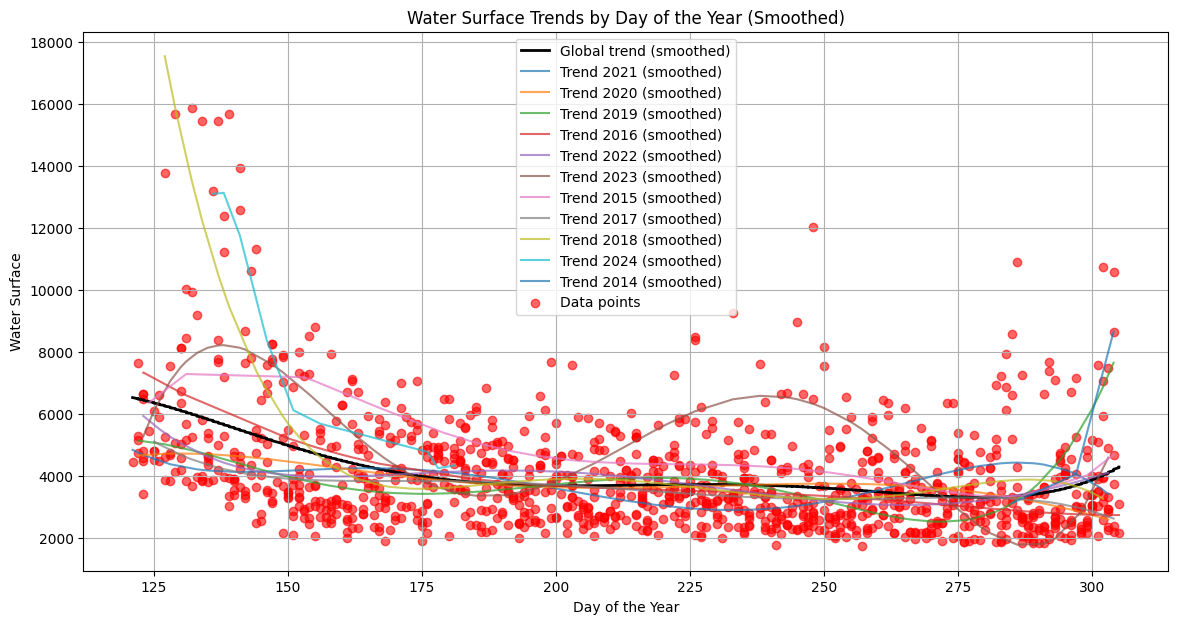

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Ensure 'combined_df' is your dataframe
input = input.sort_values('day_of_year')

# Global Polynomial Model
poly = PolynomialFeatures(degree=5)
X_global = poly.fit_transform(input['day_of_year'].values.reshape(-1, 1))  # Only use 'day_of_year'
model_global = LinearRegression().fit(X_global, input['water'])

# Global predictions with smoothing
predictions_global = model_global.predict(X_global)
smoothed_global = savgol_filter(predictions_global, 5, 3)  # Applying smoothing

# Yearly Models and Smoothing
years = input['year'].unique()
predictions_by_year = {}

for year in years:
    data_year = input[input['year'] == year]
    X_year = poly.fit_transform(data_year['day_of_year'].values.reshape(-1, 1))  # Only use 'day_of_year'
    model_year = LinearRegression().fit(X_year, data_year['water'])
    predictions_by_year[year] = model_year.predict(X_year)
    # Apply smoothing to the yearly predictions
    predictions_by_year[year] = savgol_filter(predictions_by_year[year], 3, 2)

# Plotting the results
plt.figure(figsize=(14, 7))

# Global trend
plt.plot(input['day_of_year'], smoothed_global, color='black', label='Global trend (smoothed)', linewidth=2)

# Yearly trends
for year in predictions_by_year:
    plt.plot(input[input['year'] == year]['day_of_year'], 
             predictions_by_year[year], 
             label=f'Trend {year} (smoothed)', alpha=0.7)

# Scatter plot of actual data points
plt.scatter(input['day_of_year'], input['water'], color='red', label='Data points', alpha=0.6)

# Labeling
plt.xlabel('Day of the Year')
plt.ylabel('Water Surface')
plt.title('Water Surface Trends by Day of the Year (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()
 

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter
import plotly.express as px
import plotly.graph_objects as go

# Assuming 'combined_df' is your dataframe
input = input.sort_values(['year', 'day_of_year'])

# Ajouter une colonne de date réelle basée sur l'année et le jour de l'année
input['date'] = pd.to_datetime(input['year'].astype(str) + input['day_of_year'].astype(str), format='%Y%j')

# Global Polynomial Model
poly = PolynomialFeatures(degree=20)
X_global = poly.fit_transform(input['day_of_year'].values.reshape(-1, 1))
model_global = LinearRegression().fit(X_global, input['water'])

# Global predictions with smoothing
predictions_global = model_global.predict(X_global)
smoothed_global = savgol_filter(predictions_global, 5, 3)  # Applying smoothing

# Yearly Models and Smoothing
years = input['year'].unique()
predictions_by_year = pd.DataFrame()

for year in years:
    data_year = input[input['year'] == year]
    X_year = poly.fit_transform(data_year['day_of_year'].values.reshape(-1, 1))
    model_year = LinearRegression().fit(X_year, data_year['water'])
    year_predictions = model_year.predict(X_year)
    smoothed_predictions = savgol_filter(year_predictions, 3, 2)
    
    temp_df = pd.DataFrame({
        'date': data_year['date'],
        'water': smoothed_predictions,
        'year': year
    })
    predictions_by_year = pd.concat([predictions_by_year, temp_df])

# Plot using Plotly Express
fig = go.Figure()

# Ajouter les tendances lissées pour chaque année
for year in years:
    yearly_data = predictions_by_year[predictions_by_year['year'] == year]
    fig.add_trace(go.Scatter(x=yearly_data['date'], y=yearly_data['water'], mode='lines', name=f'Trend {year}'))

# Ajouter la tendance globale lissée
input['smoothed_global'] = smoothed_global
fig.add_trace(go.Scatter(x=input['date'], y=input['smoothed_global'], mode='lines', name='Global Trend', line=dict(color='black', width=2)))

# Ajouter les données réelles sous forme de courbes pointillées
fig.add_trace(go.Scatter(x=input['date'], y=input['water'], mode='lines', name='Data Points', 
                         line=dict(dash='dot', color='red'), opacity=0.6))

# Affichage de la figure
fig.update_layout(xaxis_title='Date', yaxis_title='Water Surface', legend_title='Year', template='plotly_white')
fig.show()


In [30]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Supposons que 'input' soit votre dataframe
input = input.sort_values(['year', 'day_of_year'])

# Ajouter une colonne de date réelle basée sur l'année et le jour de l'année
input['date'] = pd.to_datetime(input['year'].astype(str) + input['day_of_year'].astype(str), format='%Y%j')

# Initialisation d'un DataFrame pour stocker les moyennes glissantes concaténées
concatenated_trends = pd.DataFrame()

# Taille de la fenêtre pour la moyenne glissante
window_size = 30

# Moyenne glissante progressive par année
years = input['year'].unique()

for year in years:
    data_year = input[input['year'] == year]
    water_moving_avg = []
    
    for i in range(len(data_year)):
        if i < window_size:
            # Moyenne progressive pour les premiers points
            window_avg = data_year['water'].iloc[:i+1].mean()
        else:
            # Moyenne glissante normale avec les 30 derniers points
            window_avg = data_year['water'].iloc[i-window_size+1:i+1].mean()
        
        water_moving_avg.append(window_avg)
    
    # Créer un DataFrame pour les moyennes glissantes de l'année courante
    trend_df = pd.DataFrame({
        'date': data_year['date'],
        'water_trend': water_moving_avg,
        'year': year
    })
    
    # Concaténer les tendances pour chaque année
    concatenated_trends = pd.concat([concatenated_trends, trend_df])

# Tracer les tendances concaténées
fig = go.Figure()

# Ajouter la courbe concaténée des moyennes glissantes pour chaque année
fig.add_trace(go.Scatter(x=concatenated_trends['date'], y=concatenated_trends['water_trend'], mode='lines', name='Annual Moving Averages', line=dict(color='blue')))

# Ajouter les données réelles sous forme de courbes pointillées
fig.add_trace(go.Scatter(x=input['date'], y=input['water'], mode='lines', name='Data Points', 
                         line=dict(dash='dot', color='red'), opacity=0.6))

# Affichage de la figure
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Water Surface',
    legend_title='Trend Type',
    template='plotly_white',
    title='Progressive Moving Average by Year'
)

fig.show()


In [31]:
temp_prec_ts_df

,geo,date,ice_in_depth,precipitation,snow_cover,temperature
0,None,2014-01-01,-2.820479e-18,0.000154,0.766615,275.633833
1,None,2014-01-02,-5.191748e-18,0.000318,0.544972,275.770643
2,None,2014-01-03,-4.552520e-18,0.002240,0.372297,275.980612
3,None,2014-01-04,-5.093492e-18,0.003699,0.201034,277.205277
4,None,2014-01-05,-2.815962e-18,0.000027,0.099447,275.639672
...,...,...,...,...,...,...
3871,None,2024-08-07,-5.646888e-20,0.002839,0.000000,293.172454
3872,None,2024-08-08,-9.769115e-20,0.000869,0.000000,292.707432
3873,None,2024-08-09,-1.253962e-19,0.004458,0.000000,290.042702
3874,None,2024-08-10,-9.500888e-20,0.001240,0.000000,290.183843


# Northern boreal alluvial meadows and water

In [32]:
def calculate_pixel_counts(image):
    pixel_count_stats = image.select('label').reduceRegion(
        reducer=ee.Reducer.frequencyHistogram().unweighted(),
        geometry=roi,
        scale=30,
        maxPixels=1e10
    )
    pixel_counts = ee.Dictionary(pixel_count_stats.get('label'))
    return ee.Feature(None,pixel_counts).copyProperties(image,['date'])

def format_date(image):
    return image.set('date', image.date().format('Y-MM-dd'))
'''
import sys
sys.path.append('../../wetlands_detection')
import wetlands_unsupervised_clustering

min_water_date = ee.Date('2022-09-25')
max_water_date = ee.Date('2018-05-09')
wetlands = wetlands_unsupervised_clustering.getWetlandsS2(roi, min_water_date, max_water_date)
gd_masked = gd.updateMask(wetlands)
'''

gd_ts = gd.map(format_date)
gd_ts = gd_ts.map(calculate_pixel_counts)

gd_ts_raw = ee.data.computeFeatures({
        'expression': gd_ts,
        'fileFormat': 'PANDAS_DATAFRAME'
    })


In [33]:
gd_ts_raw.head()

,geo,0,1,2,3,4,5,6,date,7,8,null
0,None,3674.0,17225.0,395.0,62.0,17.0,35.0,53.0,2015-08-03,NaN,NaN,NaN
1,None,3672.0,17227.0,395.0,62.0,17.0,35.0,53.0,2015-08-03,NaN,NaN,NaN
2,None,3672.0,17227.0,395.0,62.0,17.0,35.0,53.0,2015-08-03,NaN,NaN,NaN
3,None,3454.0,17400.0,464.0,9.0,19.0,57.0,58.0,2015-08-13,NaN,NaN,NaN
4,None,3457.0,17398.0,463.0,9.0,19.0,57.0,58.0,2015-08-13,NaN,NaN,NaN


In [34]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming gd_ts_raw is your initial DataFrame
legend_dw = {
    '0': 'Water',
    '1': 'Trees',
    '2': 'Grass',
    '3': 'Flooded Vegetation',
    '4': 'Crops',
    '5': 'Shrub and Scrub',
    '6': 'Built',
    '7': 'Bare',
    '8': 'Snow and Ice',
}

# Rename the columns based on legend_dw
gd_ts_df = gd_ts_raw.rename(columns=legend_dw)

# Drop any unnecessary columns
gd_ts_df = gd_ts_df.drop(columns=['geo', 'null'])

# Calculate the proportions
gd_ts_df_proportions = gd_ts_df.set_index('date')
gd_ts_df_proportions = gd_ts_df_proportions.div(gd_ts_df_proportions.sum(axis=1), axis=0).reset_index()

# Melt the DataFrame to long format
gd_ts_df_melted = gd_ts_df_proportions.melt(id_vars=['date'], var_name='class', value_name='proportion')

# Create the line plot
fig = px.line(gd_ts_df_melted, x='date', y='proportion', color='class', markers=False,
              color_discrete_map={
                  #"Water": "#419bdf",
                  #"Trees": "#397d49",
                  "Grass": "#88b053",
                  "Flooded Vegetation": "#7a87c6",
                  "Crops": "#e49635",
                  "Shrub and Scrub": "#dfc35a",
                  #"Built": "#c4281b",
                  "Bare": "#a59b8f",
                  #"Snow and Ice": "#b39fe1",
              })

# Adjust the title with a smaller font size
fig.update_layout(
    title=go.layout.Title(
        text="Annual proportion of the surface occupied by each land cover class. <br> Derived from the Dynamic World dataset",
        xref="paper",
        x=0.5,
        y=0.95,
        font=dict(size=14)),  # Reduce text size to 14
    xaxis=dict(
        tickformat='%d%m%Y',  # Format dates as Year
        tickmode='linear'
    )
)
# Show the graph
fig.show()

# Combine all data

In [196]:
import pandas as pd

# Calculer la moyenne annuelle de la couverture de neige
temp_prec_ts_df['year'] = temp_prec_ts_df['date'].dt.year
snow_cover_annual_mean = temp_prec_ts_df.groupby('year')['snow_cover'].mean().reset_index()
snow_cover_annual_mean['date'] = pd.to_datetime(snow_cover_annual_mean['year'].astype(str) + '-01-01')  # Positionné au 1er janvier de chaque année

# Agréger les précipitations par semaine
temp_prec_ts_df['week'] = temp_prec_ts_df['date'].dt.isocalendar().week
precipitation_weekly_sum = temp_prec_ts_df.groupby(['year', 'week'])['precipitation'].sum().reset_index()
precipitation_weekly_sum['date'] = pd.to_datetime(precipitation_weekly_sum['year'].astype(str) + '-01-01') + pd.to_timedelta(precipitation_weekly_sum['week'] - 1, unit='W')

# Optionnel: Si vous voulez garder les colonnes originales pour les graphiques
temp_prec_ts_df['snow_cover_annual_mean'] = temp_prec_ts_df['year'].map(snow_cover_annual_mean.set_index('year')['snow_cover'])
temp_prec_ts_df['precipitation_weekly_sum'] = temp_prec_ts_df['date'].map(precipitation_weekly_sum.set_index('date')['precipitation'])


In [197]:
import pandas as pd

def calculate_moving_average(temp_prec_ts_df, window=100):
    """
    Calcule la moyenne glissante pour lisser la série temporelle de température.
    
    Args:
    - temp_prec_ts_df: DataFrame contenant les données avec une colonne 'date' et 'temperature'.
    - window: Taille de la fenêtre pour la moyenne glissante (en jours).
    
    Returns:
    - DataFrame contenant les colonnes 'date', 'temperature', et 'temperature_moving_avg'.
    """
    temp_prec_ts_df = temp_prec_ts_df.sort_values('date')
    
    # Calculer la moyenne glissante
    temp_prec_ts_df['temperature_moving_avg'] = temp_prec_ts_df['temperature'].rolling(window=window, center=True).mean()
    
    return temp_prec_ts_df[['date', 'temperature', 'temperature_moving_avg']]

# Utiliser la fonction pour calculer la moyenne glissante
temperature_moving_avg_df = calculate_moving_average(temp_prec_ts_df, window=50)


In [198]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Créer une figure avec sous-graphes et axe X partagé
fig = sp.make_subplots(
    rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    subplot_titles=("Temperature (K)", "Ice Depth (m)", "Snow Cover","Water Surface derived from Sentinel 1 and Dynamic World dataset", "Weekly sum precipitation")
)

# Tracer les courbes pour chaque sous-graphe
fig.add_trace(go.Scatter(x=temp_prec_ts_df['date'], y=temp_prec_ts_df['temperature'], mode='lines', name='Temperature (K)', line=dict(color='red', dash='dot')), row=1, col=1)
#fig.add_trace(go.Scatter(x=temperature_trend_df['date'], y=temperature_trend_df['temperature_trend'], mode='lines', name='Temperature trend', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=temperature_moving_avg_df['date'], y=temperature_moving_avg_df['temperature_moving_avg'], mode='lines', name='Temperature rolling average', line=dict(color='red')), row=1, col=1)

fig.add_trace(go.Scatter(x=temp_prec_ts_df['date'], y=temp_prec_ts_df['ice_in_depth'], mode='lines', name='Ice Depth (m)', line=dict(color='grey')), row=2, col=1)

# Tracer Snow Cover et sa moyenne annuelle (positionnée au 1er janvier)
fig.add_trace(go.Scatter(x=temp_prec_ts_df['date'], y=temp_prec_ts_df['snow_cover'], mode='lines', name='Snow Cover', line=dict(color='green', dash='dot')), row=3, col=1)
fig.add_trace(go.Scatter(x=snow_cover_annual_mean['date'], y=snow_cover_annual_mean['snow_cover'], mode='markers+lines', name='Annual Mean Snow Cover', line=dict(color='green')), row=3, col=1)

# Tracer Water Surface et les tendances annuelles
fig.add_trace(go.Scatter(x=combined_df['date'], y=combined_df['water'], mode='lines', name='Water Surface', line=dict(dash='dot', color='blue'), opacity=0.6), row=4, col=1)
#fig.add_trace(go.Scatter(x=concatenated_trends['date'], y=concatenated_trends['water_trend'], mode='lines', name='Annual Trends', line=dict(color='blue')), row=4, col=1)

# Ajouter la courbe de la moyenne glissante progressive par année
fig.add_trace(go.Scatter(x=concatenated_trends['date'], y=concatenated_trends['water_trend'], mode='lines', name='Progressive Moving Avg by Year', line=dict(color='blue')), row=4, col=1)

# Tracer les précipitations hebdomadaires
fig.add_trace(go.Scatter(x=precipitation_weekly_sum['date'], y=precipitation_weekly_sum['precipitation'], mode='lines', name='Precipitation (Weekly Sum)', line=dict(color='blue')), row=5, col=1)

# Ajouter une ligne horizontale à 273.15 K (0°C) sur le graphe de température avec une légende
fig.add_trace(go.Scatter(
    x=[temp_prec_ts_df['date'].min(), temp_prec_ts_df['date'].max()],
    y=[273.15, 273.15],
    mode="lines",
    name="0°C (273.15 K)",
    line=dict(color="red", width=2, dash="dash")
), row=1, col=1)

# Mettre à jour la mise en page pour ajouter des titres et la légende
fig.update_layout(
    height=1000,
    showlegend=True,
    title_text="",
    legend=dict(x=0.01, y=1.02, traceorder='normal', font=dict(size=10)),
    margin=dict(l=50, r=50, t=50, b=50)
)

# Ajouter les titres des axes Y
fig.update_yaxes(title_text="Temperature (K)", row=1, col=1)
fig.update_yaxes(title_text="Ice Depth (m)", row=2, col=1)
fig.update_yaxes(title_text="Snow Cover", row=3, col=1)
fig.update_yaxes(title_text="Water Surface", row=4, col=1)
fig.update_yaxes(title_text="Precipitation", row=5, col=1)

# Ajouter le titre de l'axe X pour l'axe partagé
fig.update_xaxes(title_text="Date", row=5, col=1)

fig.show()
